<a href="https://colab.research.google.com/github/lorenzoridolfi9/Japanese-newspapers-classification/blob/main/Japanese_newspapers_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from psutil import virtual_memory
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data cleaning
import nltk
from nltk.corpus import stopwords
import string
import re
import spacy

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import torch
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE


#keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, GRU, Dense, Dropout, Input, Bidirectional, Flatten, TimeDistributed
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.backend import clear_session
from keras.metrics import Precision, Recall
from keras.layers import GlobalMaxPooling1D

# Transformers
from transformers import TFAutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel
from transformers import GPT2Tokenizer, TFGPT2Model





import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Check if a GPU is available
try:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
except Exception as e:
    print('Errore durante il controllo della GPU:', e)


Fri Feb 23 13:38:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Check if a high RAM is available
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
###### THIS CELL NEED 20 MINUTES #######

# Load dataset files
uploaded_english = files.upload()
uploaded_japanese = files.upload()

# Print datasets name
print("Names of the loaded datasets: ")
for filename in uploaded_english.keys():
    print(f"English file: {filename}")

for filename in uploaded_japanese.keys():
    print(f"Japanese file: {filename}")


Saving english_news.csv to english_news.csv


Saving japanese_news.csv to japanese_news.csv
Names of the loaded datasets: 
English file: english_news.csv
Japanese file: japanese_news.csv


In [3]:
# Read English DataFrame
data_english = pd.read_csv("english_news.csv", sep="\t", header=0)

print("English DataFrame:")
data_english.head(10)

English DataFrame:


,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...
5,Mainichi Shimbun,2021-12-09,News Navigator: What is 'Olympic diplomacy'?,NaN,The Mainichi Shimbun answers some common quest...
6,Mainichi Shimbun,2021-12-09,Editorial: Japan's main opposition CDP has tur...,NaN,"During party leaders' questions, which began a..."
7,Mainichi Shimbun,2021-12-10,News Navigator: How does the Japanese-develope...,NaN,The Mainichi Shimbun answers some common quest...
8,Mainichi Shimbun,2021-12-10,Editorial: Japan PM's response weak on 1 mil. ...,NaN,Calls have arisen for a review of a 1 million ...
9,Mainichi Shimbun,2021-12-11,Edging Toward Japan: Inspiration from Anpan Ma...,By,"Recently, my 9-year-old daughter mentioned in ..."


In [4]:
# Read Japanese DataFrame
data_japanese = pd.read_csv("japanese_news.csv", sep="\t", header=0)

print("Japanese DataFrame:")
data_japanese.head(10)

Japanese DataFrame:


,source,date,title,author,text
0,kobe-np.co.jp,2005-07-01,NaN,NaN,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...
1,kobe-np.co.jp,2005-07-01,NaN,NaN,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...
2,kobe-np.co.jp,2007-04-07,NaN,NaN,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...
3,kobe-np.co.jp,2007-04-07,NaN,NaN,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。
4,kobe-np.co.jp,2007-04-07,NaN,NaN,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...
5,kobe-np.co.jp,2007-04-07,NaN,NaN,弁護側によると、四人の被告のうち、金沢被告は上告する意思を示しているという。（川口洋光、大月美佳）
6,kobe-np.co.jp,2007-04-07,NaN,NaN,「われわれの苦しみと悲しみは一生消えない」。ずさんな警備で多数の死傷者が出た明石・歩道橋事故...
7,kobe-np.co.jp,2007-04-07,NaN,NaN,この日、裁判長は「被告以外に過失責任を問われる余地がある者もいる」として、被告以外の関係者の...
8,hokkaido-np.co.jp,2007-04-28,NaN,NaN,とても心配です。最下位に低迷している日本ハムに「またか、どうしたの！」と言いながら、少しずつ...
9,hokkaido-np.co.jp,2007-04-28,NaN,NaN,■反省 離れていく心が心配


In [5]:
# PREPROCESSING

# Checks whether the DataFrames have the same columns
if data_japanese.columns.equals(data_english.columns):
    print("DataFrame columns match!")
else:
    assert False, "DataFrame columns do not match"


DataFrame columns match!


In [6]:
# Number of records for each class of English DataFrame
data_english["source"].value_counts()

The Japan Times     36815
Mainichi Shimbun       74
Name: source, dtype: int64

In [7]:
# Number of records for each class of Japanese DataFrame
data_japanese["source"].value_counts()

mainichi.jp          44657
sankei.jp.msn.com    35959
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64

In [8]:
# Check null values for English DataFrame in text column
print("Null values in the English DataFrame:")
data_english.groupby("source").text.apply(lambda x: x.isna().sum())

Null values in the English DataFrame:


source
Mainichi Shimbun      0
The Japan Times     123
Name: text, dtype: int64

In [9]:
# Check null values for Japanese DataFrame in text column
print("Null values in the Japanese DataFrame:")
data_japanese.groupby("source").text.apply(lambda x: x.isna().sum())

Null values in the Japanese DataFrame:


source
asahi.com            0
chunichi.co.jp       0
hokkaido-np.co.jp    0
isenp.co.jp          0
iwate-np.co.jp       0
kobe-np.co.jp        0
kyoto-np.co.jp       0
mainichi.jp          1
nikkansports.com     0
nikkei.com           0
nishinippon.co.jp    0
nnn.co.jp            0
oita-press.co.jp     0
sankei.jp.msn.com    0
sanspo.com           0
shimotsuke.co.jp     0
tokachi.co.jp        0
tokyo-np.co.jp       0
tomamin.co.jp        0
yamagata-np.jp       0
yomiuri.co.jp        0
Name: text, dtype: int64

In [10]:
# Delete rows with null values
data_english = data_english.dropna(subset=['text'])
data_japanese = data_japanese.dropna(subset=['text'])

In [11]:
# Find duplicate rows grouped by "source" in the English DataFrame
data_english[data_english.duplicated()].groupby("source").size()

source
The Japan Times    785
dtype: int64

In [12]:
# Find duplicate rows grouped by "source" in the Japanese DataFrame
data_japanese[data_japanese.duplicated()].groupby("source").size()

Series([], dtype: int64)

In [13]:
# Remove duplicate rows for English dataframe
data_english.drop_duplicates(inplace=True)
data_japanese.drop_duplicates(inplace=True)

In [14]:
#EDA: EXPLORATORY DATA ANALYSIS FOR ENGLISH DATASET

# SOURCE

# Number of source in dataset
source_counts_en = data_english['source'].value_counts()

# Calculate the average of the observations per class
mean_en = round(source_counts_en.mean())

# Class with the max number of observations
class_max_en = source_counts_en.idxmax()
max_en = source_counts_en.max()

# Class with the min number of observations
class_min_en = source_counts_en.idxmin()
min_en = source_counts_en.min()

print("Number of records per class in English dataset:\n", source_counts_en)
print("Average of records per class in English dataset:", mean_en)
print("Class with the maximum number of records in English dataset:", class_max_en, "with", max_en, "records")
print("Class with the minimum number of records in English dataset:", class_min_en, "with", min_en, "records")


Number of records per class in English dataset:
 The Japan Times     35907
Mainichi Shimbun       74
Name: source, dtype: int64
Average of records per class in English dataset: 17990
Class with the maximum number of records in English dataset: The Japan Times with 35907 records
Class with the minimum number of records in English dataset: Mainichi Shimbun with 74 records


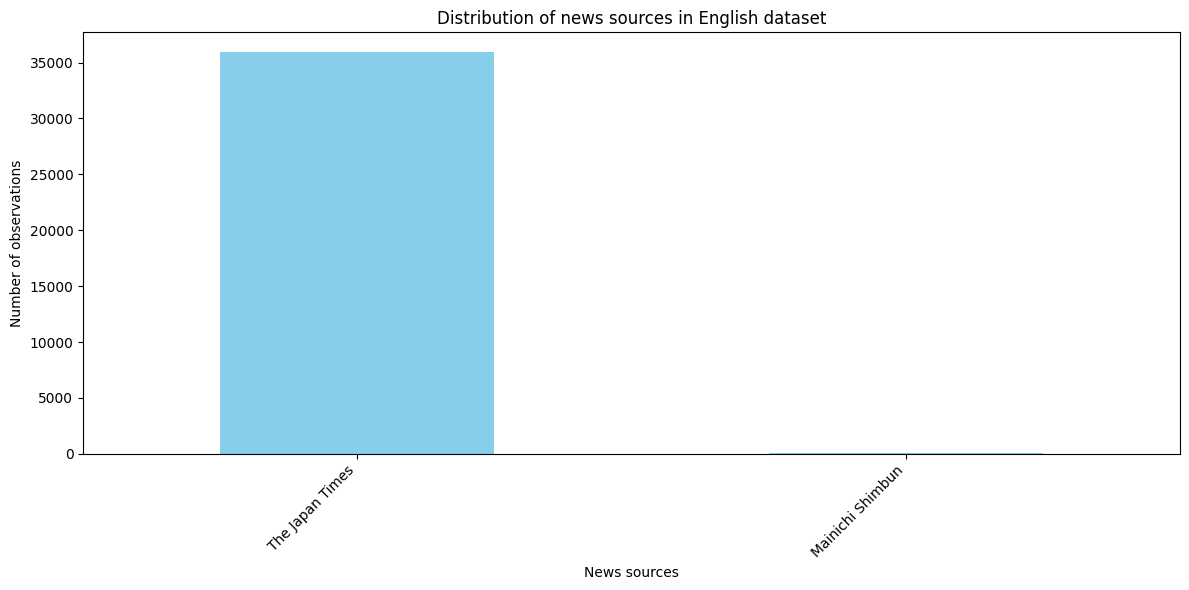

In [ ]:
# Create a bar graph to see the number of observations for each class
plt.figure(figsize=(12, 6))
source_counts_en.plot(kind='bar', color='skyblue')
plt.title('Distribution of news sources in English dataset')
plt.xlabel('News sources')
plt.ylabel('Number of observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#EDA: EXPLORATORY DATA ANALYSIS FOR JAPANESE DATASET

# SOURCE

# Number of source in dataset
source_counts_ja = data_japanese['source'].value_counts()

# Calculate the average of the observations per class
mean_ja = round(source_counts_ja.mean())

# Class with the max number of observations
class_max_ja = source_counts_ja.idxmax()
max_ja = source_counts_ja.max()

# Class with the min number of observations
class_min_ja = source_counts_ja.idxmin()
min_ja = source_counts_ja.min()

print("Number of records per class in Japanese dataset:\n", source_counts_ja)
print("Average of records per class in Japanese dataset:", mean_ja)
print("Class with the maximum number of records in Japanese dataset:", class_max_ja, "with", max_ja, "records")
print("Class with the minimum number of records in Japanese dataset:", class_min_ja, "with", min_ja, "records")

Number of records per class in Japanese dataset:
 mainichi.jp          44656
sankei.jp.msn.com    35959
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64
Average of records per class in Japanese dataset: 14903
Class with the maximum number of records in Japanese dataset: mainichi.jp with 44656 records
Class with the minimum number of records in Japanese dataset: tokyo-np.co.jp with 65 records


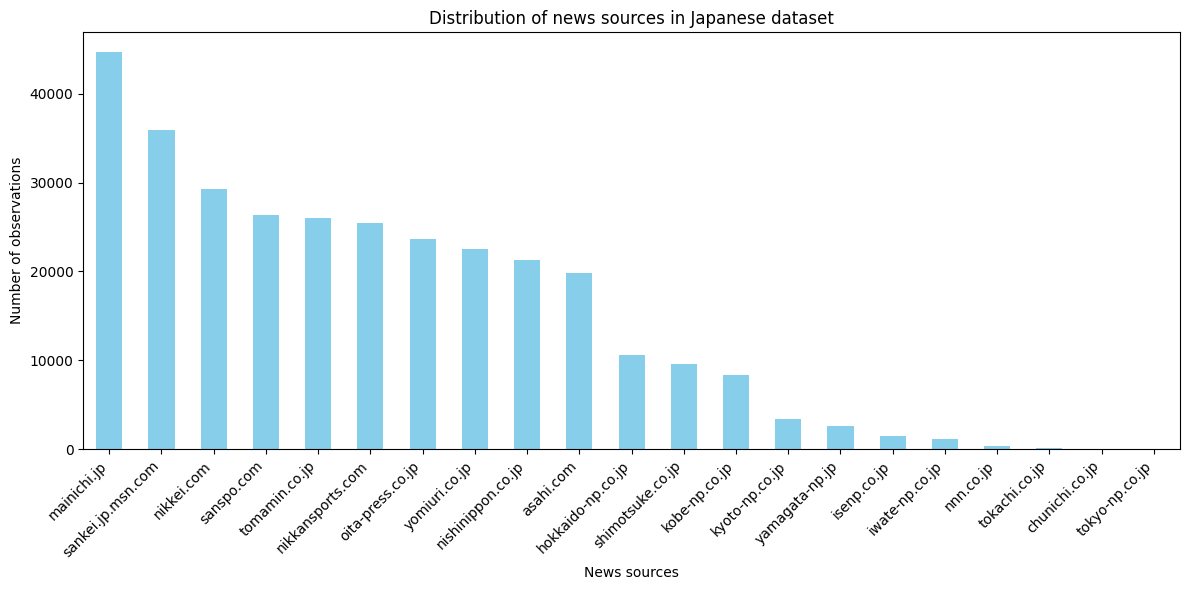

In [ ]:
# Create a bar graph to see the number of observations for each class
plt.figure(figsize=(12, 6))
source_counts_ja.plot(kind='bar', color='skyblue')
plt.title('Distribution of news sources in Japanese dataset')
plt.xlabel('News sources')
plt.ylabel('Number of observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

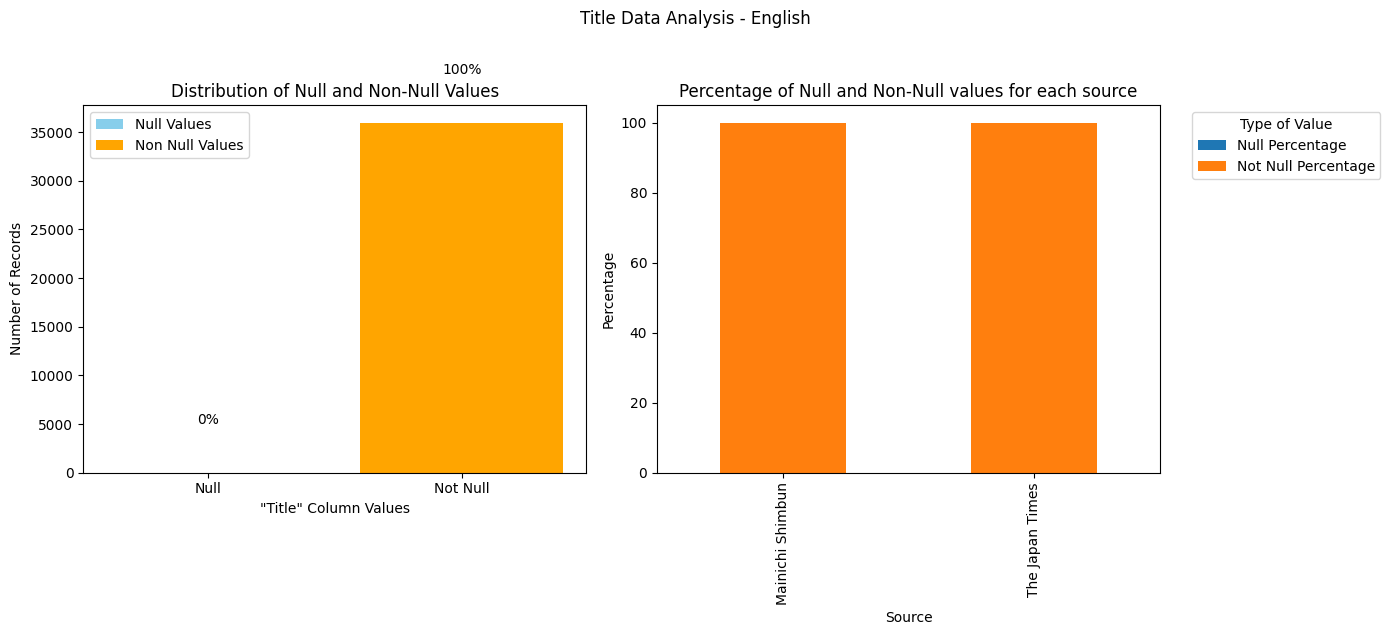

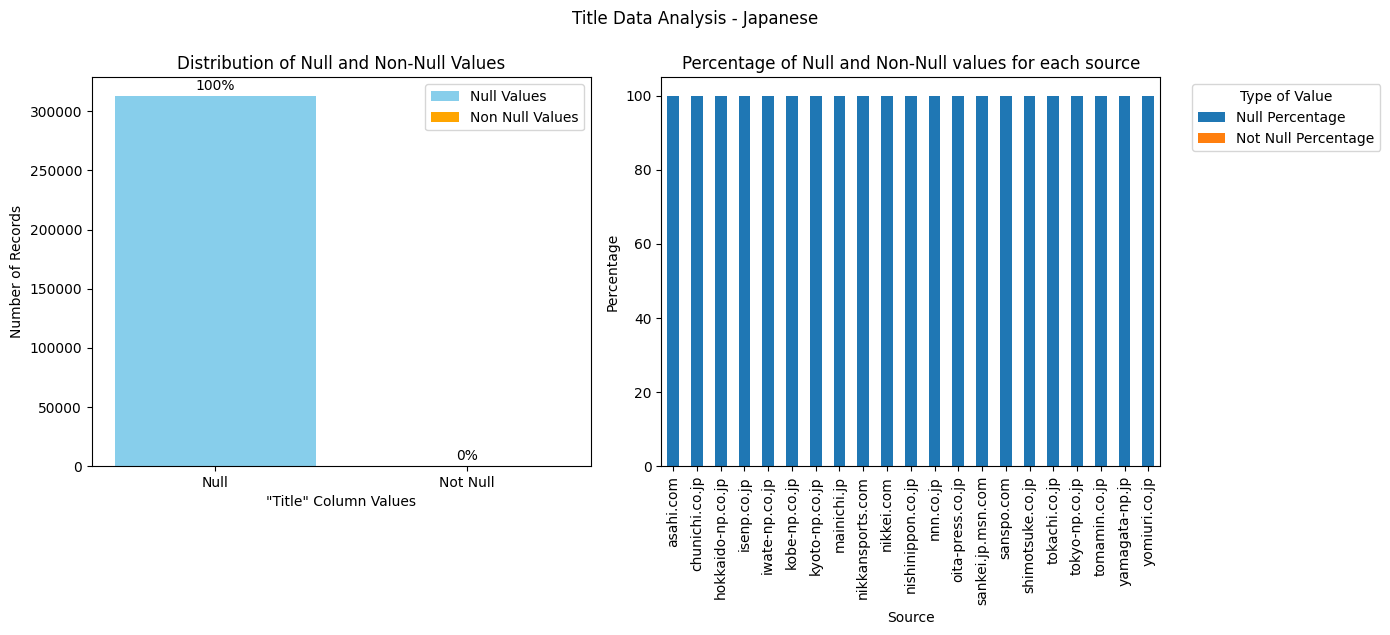

In [ ]:
# TITLE

def plot_title_data(data, language):
    # Calculate the total number of null and non-null values in the 'title' column
    total_null_values_title = data['title'].isnull().sum()
    total_not_null_values_title = data['title'].notnull().sum()
    total_values_title = len(data)

    # Calculate the percentages of null and non-null values
    null_percentage_title = (total_null_values_title / total_values_title) * 100
    not_null_percentage_title = (total_not_null_values_title / total_values_title) * 100

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First subplot - Distribution of Null and Non-Null Values in the "Title" Column
    axes[0].bar(x='Null', height=total_null_values_title, color='skyblue', label='Null Values')
    axes[0].bar(x='Not Null', height=total_not_null_values_title, color='orange', label='Non Null Values')

    axes[0].text('Null', total_null_values_title + 5000, f'{null_percentage_title:.0f}%', ha='center')
    axes[0].text('Not Null', total_not_null_values_title + 5000, f'{not_null_percentage_title:.0f}%', ha='center')

    axes[0].set_xlabel('"Title" Column Values')
    axes[0].set_ylabel('Number of Records')
    axes[0].set_title('Distribution of Null and Non-Null Values')
    axes[0].legend()

    # Group the DataFrame by the "source" column and calculate the count of null and non-null values for the "title" column
    source_counts_title = data.groupby('source')['title'].agg([lambda x: x.isnull().sum(), lambda x: x.notnull().sum()])

    # Rename the columns for clarity
    source_counts_title.columns = ['Null', 'Not Null']

    # Calculate the percentages of null and non-null values for each source
    source_counts_title['Null Percentage'] = (source_counts_title['Null'] / (source_counts_title['Null'] + source_counts_title['Not Null'])) * 100
    source_counts_title['Not Null Percentage'] = (source_counts_title['Not Null'] / (source_counts_title['Null'] + source_counts_title['Not Null'])) * 100

    # Second subplot - Percentage of Null and Non-Null values for each source
    source_counts_title[['Null Percentage', 'Not Null Percentage']].plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Percentage of Null and Non-Null values for each source')
    axes[1].set_xlabel('Source')
    axes[1].set_ylabel('Percentage')
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].legend(title='Type of Value', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle(f'Title Data Analysis - {language.capitalize()}', y=1.05)
    plt.show()


plot_title_data(data_english, 'english')
plot_title_data(data_japanese, 'japanese')


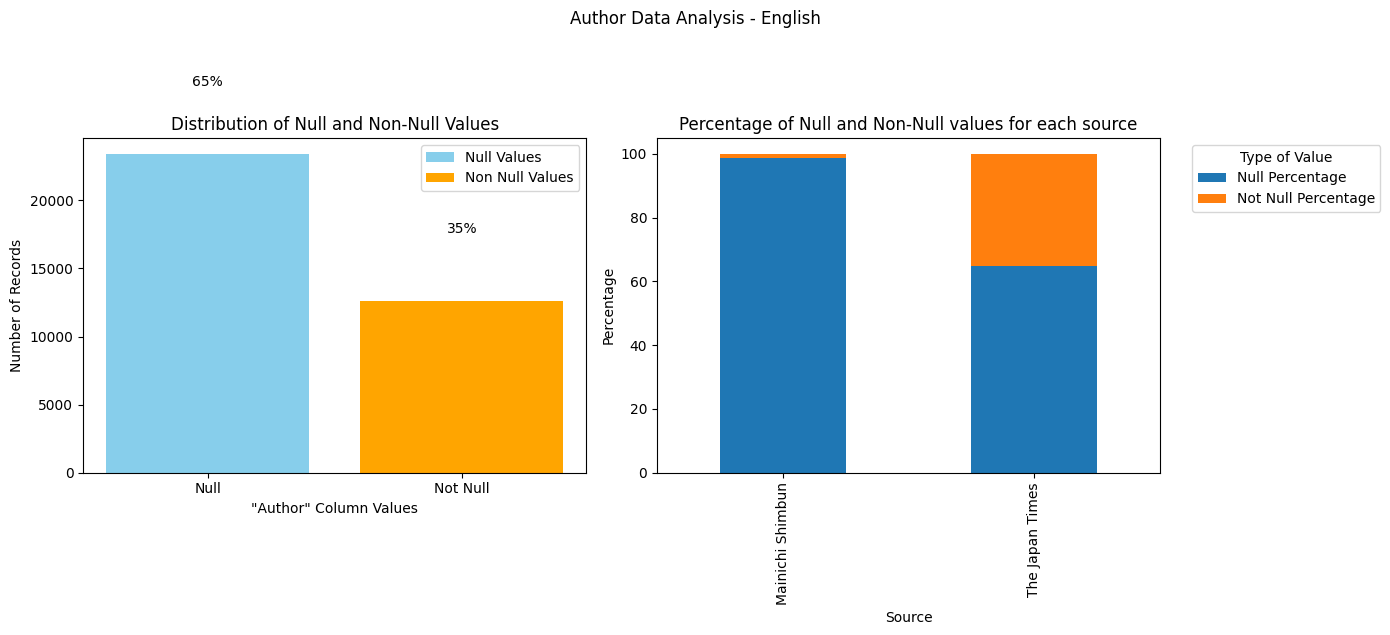

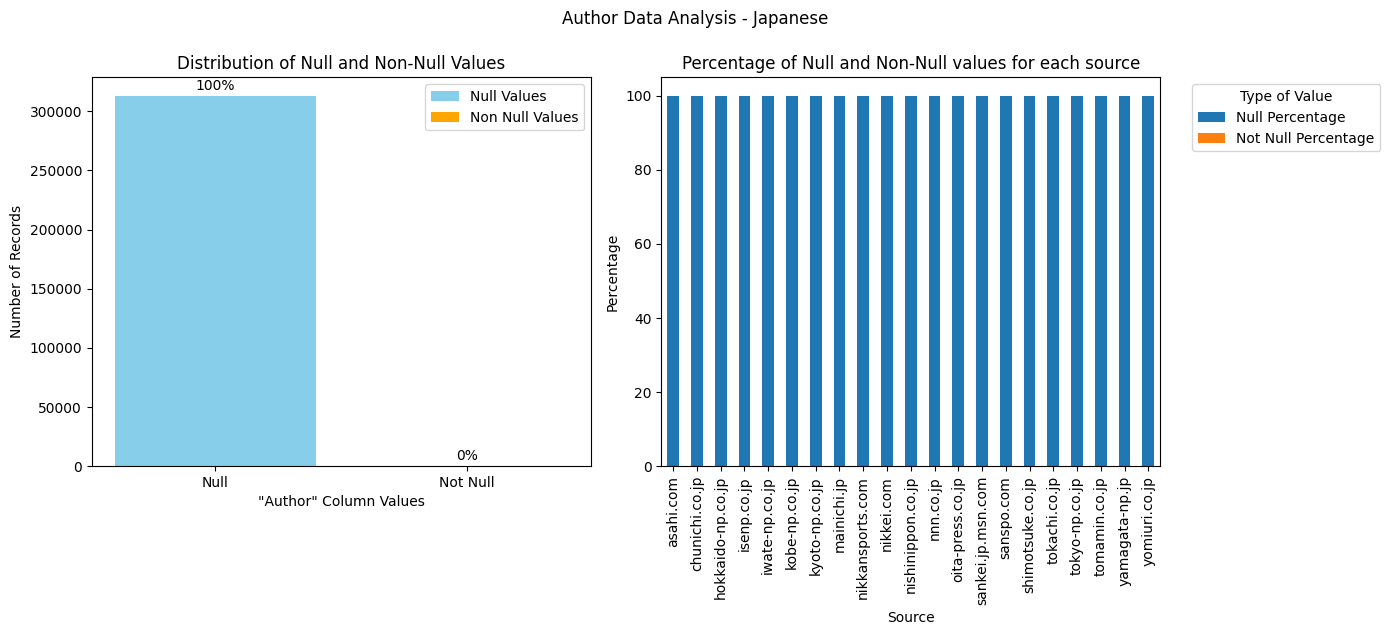

In [ ]:
# AUTHOR

def plot_author_data(data, language):
    # Calculate the total number of null and non-null values in the 'author' column
    total_null_values_author = data['author'].isnull().sum()
    total_not_null_values_author = data['author'].notnull().sum()
    total_values_author = len(data)

    # Calculate the percentages of null and non-null values
    null_percentage_author = (total_null_values_author / total_values_author) * 100
    not_null_percentage_author = (total_not_null_values_author / total_values_author) * 100

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First subplot - Distribution of Null and Non-Null Values in the "Author" Column
    axes[0].bar(x='Null', height=total_null_values_author, color='skyblue', label='Null Values')
    axes[0].bar(x='Not Null', height=total_not_null_values_author, color='orange', label='Non Null Values')

    axes[0].text('Null', total_null_values_author + 5000, f'{null_percentage_author:.0f}%', ha='center')
    axes[0].text('Not Null', total_not_null_values_author + 5000, f'{not_null_percentage_author:.0f}%', ha='center')

    axes[0].set_xlabel('"Author" Column Values')
    axes[0].set_ylabel('Number of Records')
    axes[0].set_title('Distribution of Null and Non-Null Values')
    axes[0].legend()

    # Group the DataFrame by the "source" column and calculate the count of null and non-null values for the "author" column
    source_counts_author = data.groupby('source')['author'].agg([lambda x: x.isnull().sum(), lambda x: x.notnull().sum()])

    # Rename the columns for clarity
    source_counts_author.columns = ['Null', 'Not Null']

    # Calculate the percentages of null and non-null values for each source
    source_counts_author['Null Percentage'] = (source_counts_author['Null'] / (source_counts_author['Null'] + source_counts_author['Not Null'])) * 100
    source_counts_author['Not Null Percentage'] = (source_counts_author['Not Null'] / (source_counts_author['Null'] + source_counts_author['Not Null'])) * 100

    # Second subplot - Percentage of Null and Non-Null values for each source
    source_counts_author[['Null Percentage', 'Not Null Percentage']].plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Percentage of Null and Non-Null values for each source')
    axes[1].set_xlabel('Source')
    axes[1].set_ylabel('Percentage')
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].legend(title='Type of Value', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle(f'Author Data Analysis - {language.capitalize()}', y=1.05)
    plt.show()


plot_author_data(data_english, 'english')

plot_author_data(data_japanese, 'japanese')


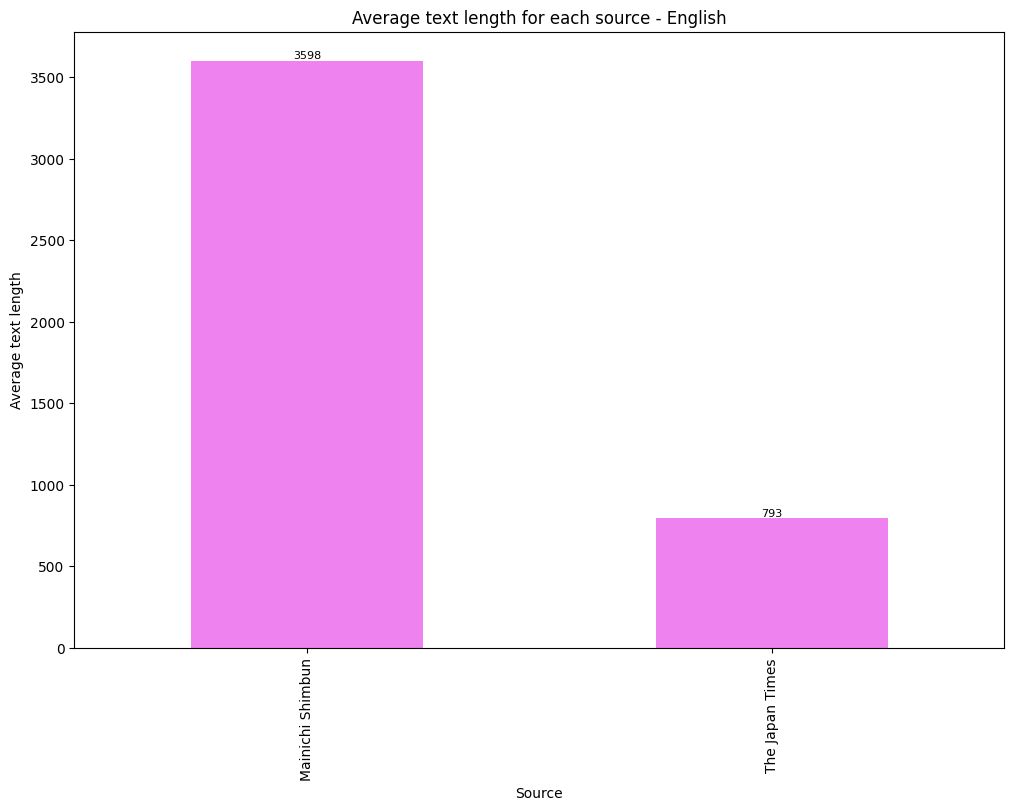

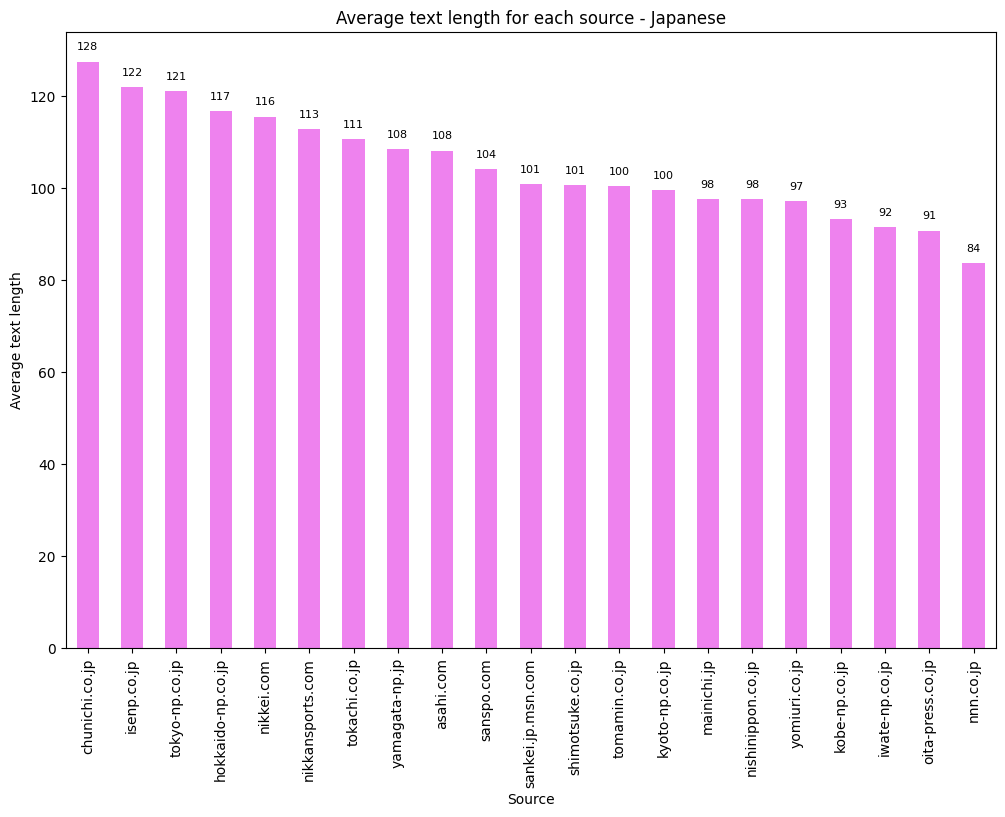

In [ ]:
# TEXT

def plot_average_text_length(data, language):
    # Calculate the length of each text in the "text" column
    data['text_length'] = data['text'].apply(lambda x: len(str(x)))

    source_text_length = data.groupby('source')['text_length'].mean().sort_values(ascending=False)

    # Create bar graph
    plt.figure(figsize=(12, 8))
    ax = source_text_length.plot(kind='bar', color='violet')
    plt.xlabel('Source')
    plt.ylabel('Average text length')
    plt.title(f'Average text length for each source - {language.capitalize()}')
    plt.xticks(rotation=90)

    for i, v in enumerate(source_text_length):
        ax.text(i, v + 2, f'{v:.0f}', ha='center', va='bottom', fontsize=8)

    plt.show()


plot_average_text_length(data_english, 'english')

plot_average_text_length(data_japanese, 'japanese')


In [15]:
# DATA CLEANING

def data_cleaning(dataframe, language="english"):

    nltk.download("stopwords")

    # Initialize spacy models for English and Japanese
    if language == "english":
        stop_words = set(stopwords.words(language))
        !python -m spacy download en_core_web_md
        nlp = spacy.load("en_core_web_md")
    elif language == "japanese":
        !python -m spacy download ja_core_news_md
        nlp = spacy.load("ja_core_news_md")
    else:
        raise ValueError("Unsupported language")

    # Define punctuation set
    punctuation = set(string.punctuation + "・、。「 」『 』")


    df_cleaned = []

    # Iterate through each sentence in the dataframe
    for sentence in dataframe:
        # Convert sentence to lowercase
        sentence = sentence.lower()

        # Tokenize the sentence
        tokens = sentence.split()

        # Remove stopwords and punctuation, lemmatize tokens
        if language == "english":
            cleaned_tokens = [token.lemma_ for token in nlp(" ".join(tokens)) if token.lemma_ not in stop_words and token.lemma_ not in punctuation]
        elif language == "japanese":
            cleaned_tokens = [token.lemma_ for token in nlp(" ".join(tokens)) if token.lemma_ not in punctuation]
        else:
            raise ValueError("Unsupported language")

        # Remove digits and redundant spaces
        cleaned_tokens = [re.sub(r"\d", "", token) for token in cleaned_tokens]
        cleaned_tokens = [re.sub(r"\s+", " ", token) for token in cleaned_tokens]

        # Join the cleaned tokens back into a sentence
        cleaned_sentence = " ".join(cleaned_tokens)

        # Append cleaned sentence to the list
        df_cleaned.append(cleaned_sentence)

    return df_cleaned



In [16]:
data_english=data_english[["text", "source"]]
data_english.head(10)

,text,source
0,The Japanese government is trying to boost the...,Mainichi Shimbun
1,"Prime Minister Fumio Kishida, who won a public...",Mainichi Shimbun
2,It has been 80 years since the start of the Pa...,Mainichi Shimbun
3,"""The world has changed completely. The era was...",Mainichi Shimbun
4,The U.S. administration under President Joe Bi...,Mainichi Shimbun
5,The Mainichi Shimbun answers some common quest...,Mainichi Shimbun
6,"During party leaders' questions, which began a...",Mainichi Shimbun
7,The Mainichi Shimbun answers some common quest...,Mainichi Shimbun
8,Calls have arisen for a review of a 1 million ...,Mainichi Shimbun
9,"Recently, my 9-year-old daughter mentioned in ...",Mainichi Shimbun


In [17]:
data_japanese=data_japanese[["text", "source"]]
data_japanese.head(10)

,text,source
0,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...,kobe-np.co.jp
1,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...,kobe-np.co.jp
2,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...,kobe-np.co.jp
3,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。,kobe-np.co.jp
4,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...,kobe-np.co.jp
5,弁護側によると、四人の被告のうち、金沢被告は上告する意思を示しているという。（川口洋光、大月美佳）,kobe-np.co.jp
6,「われわれの苦しみと悲しみは一生消えない」。ずさんな警備で多数の死傷者が出た明石・歩道橋事故...,kobe-np.co.jp
7,この日、裁判長は「被告以外に過失責任を問われる余地がある者もいる」として、被告以外の関係者の...,kobe-np.co.jp
8,とても心配です。最下位に低迷している日本ハムに「またか、どうしたの！」と言いながら、少しずつ...,hokkaido-np.co.jp
9,■反省 離れていく心が心配,hokkaido-np.co.jp


In [ ]:
text_eng_cleaned = data_cleaning(data_english["text"], language="english")

data_english_cleaned = pd.DataFrame(data={"text": text_eng_cleaned,
                                    "source": list(data_english["source"])})

data_english_cleaned.to_csv("english_news_cleaned.csv", index=False)

files.download("english_news_cleaned.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 25.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### THIS CELL NEED 1 HOUR ###
text_ja_cleaned = data_cleaning(data_japanese["text"], language="japanese")

data_ja_cleaned = pd.DataFrame(data={"text": text_ja_cleaned,
                                    "source": list(data_japanese["source"])})

data_ja_cleaned.to_csv("japanese_news_cleaned.csv", index=False)

files.download("japanese_news_cleaned.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 MB 784.6 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Concatenate the English dataset with the Japanese dataset
data_ja_cleaned = pd.read_csv("japanese_news_cleaned.csv")
data_english_cleaned = pd.read_csv("english_news_cleaned.csv")
dataset_complete = pd.concat([data_ja_cleaned, data_english_cleaned], ignore_index=True)

dataset_complete = dataset_complete.dropna()
num_rows, num_columns = dataset_complete.shape
dataset_complete.info()
dataset_complete.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348929 entries, 0 to 348934
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    348929 non-null  object
 1   source  348929 non-null  object
dtypes: object(2)
memory usage: 8.0+ MB


,text,source
0,会見 する た 北口 寛人 市長 は 刑事 訴訟 で 被告 と なる て いる 職員 に は...,kobe-np.co.jp
1,明石 歩道 橋 事故 を めぐる 民事 訴訟 で 神戸 地裁 から 計 五億六千八百万 円 ...,kobe-np.co.jp
2,会見 後 遺族 代理 人 の 渡部 吉泰 弁護 士 は 裁判 長 が 問う べし 者 を 問...,kobe-np.co.jp
3,遺族 会 は 雑踏 警備 本部 長 を 務める た 元 明石 署 長 ら 二人 の 起訴 を...,kobe-np.co.jp
4,五 人 の 遺族 が 閉廷 後 に 会見 二女 の 優衣菜 ちゃん 当時 つ を 亡くす ...,kobe-np.co.jp
5,弁護 側 に よる と 四 人 の 被告 の うち 金沢 被告 は 上告 する 意思 を 示...,kobe-np.co.jp
6,われわれ の 苦しい み と 悲しい み は 一生 消える ない ずさん だ 警備 で 多数...,kobe-np.co.jp
7,この 日 裁判 長 は 被告 以外 に 過失 責任 を 問う れる 余地 が ある 者 も ...,kobe-np.co.jp
8,とても 心配 です 最 下位 に 低迷 する て いる 日本 ハム に また か どう する...,hokkaido-np.co.jp
9,■ 反省 離れる て いく 心 が 心配,hokkaido-np.co.jp


In [20]:
# Number of source in dataset
source_counts_complete = dataset_complete['source'].value_counts()
print(source_counts_complete)

mainichi.jp          44656
sankei.jp.msn.com    35959
The Japan Times      35907
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22466
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
Mainichi Shimbun        74
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64


In [21]:
# UNDERSAMPLING

# Undersampling of majority classes based on character frequency

# Calculate the frequency of terms for each class
class_counts = Counter(dataset_complete['source'])
classes_to_truncate = [classe for classe, count in class_counts.items() if count > 13000]

term_frequencies = {}
for classe in classes_to_truncate:
    term_frequencies[classe] = Counter(dataset_complete[dataset_complete['source'] == classe]['text'])

# Select the records with the highest frequency
undersampled_df = pd.DataFrame()
for classe in classes_to_truncate:
    most_frequent_terms = sorted(term_frequencies[classe].items(), key=lambda x: x[1], reverse=True)[:13000]
    temp_df = dataset_complete[dataset_complete['source'] == classe]
    temp_df = temp_df[temp_df['text'].isin([term[0] for term in most_frequent_terms])]
    undersampled_df = pd.concat([undersampled_df, temp_df], ignore_index=True)

# Concatenate records from other classes
other_classes_df = dataset_complete[~dataset_complete['source'].isin(classes_to_truncate)]
dataset_undersampled = pd.concat([undersampled_df, other_classes_df], ignore_index=True)

print("Number of records per class:\n", dataset_undersampled['source'].value_counts())
print(dataset_undersampled.head())


Number of records per class:
 nikkansports.com     13763
mainichi.jp          13738
nishinippon.co.jp    13379
yomiuri.co.jp        13329
oita-press.co.jp     13161
nikkei.com           13142
asahi.com            13123
sankei.jp.msn.com    13121
The Japan Times      13054
sanspo.com           13038
tomamin.co.jp        13022
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
Mainichi Shimbun        74
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64
                                                text            source
0  サッカー 日本 代表 イビチャ オシム 監督  の 後任 に 浦和 監督 の ホルガー オジ...  nikkansports.com
1  オジェック 氏 に は まだ クラブ W杯 と 天皇 杯 が 残る て いる  月  日 か...  nikkansports.com
2  オジェック 氏 と 浦和 の 契約 は 今季 いっぱい 浦和 側 は 契約 延長 の オファ...  nikkansports.com
3  オシム 監督 の 体調 不安 は 就任 時 から 言う れる て くる

In [22]:
# Confusion matrix
def plot_confusion_matrix(X_test,y_test,y_pred):

  conf_mat = confusion_matrix(y_test, y_pred)

  counter=dataset_complete.groupby("source")["text"].count()
  y=counter.to_dict().keys()

  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=y, yticklabels=y)
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()

In [23]:
# TEXT VECTORIALIZATION: TF-IDF

def bow_tfidf(dataset,tfidf_vectorizer, max_features=1000):

    if tfidf_vectorizer==None:
        tfidf_vectorizer=TfidfVectorizer(max_features=max_features)
        X=tfidf_vectorizer.fit_transform(dataset)
    else:
        X=tfidf_vectorizer.transform(dataset)
    return X.toarray(), tfidf_vectorizer

In [24]:
# TEXT VECTORIALIZATION: BERT

def bert_transform(dataset, tokenizer, model, max_length=100):

    embeddings = []
    for text in tqdm(dataset, desc="BERT Processing"):
        inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings.append(cls_embedding)
    return embeddings



In [25]:
# Train and test set
X_train,X_test,y_train,y_test=train_test_split(dataset_undersampled["text"], dataset_undersampled["source"], test_size=0.20, stratify=dataset_undersampled["source"], random_state=42)


In [ ]:
#### THIS CELL NEED 2H, 60GB RAM AND 40 GPU A100 ####
# Vectorialization with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Vectorize the data
X_train_embeddings = bert_transform(X_train, tokenizer, model, max_length=100)
X_test_embeddings = bert_transform(X_test, tokenizer, model, max_length=100)

# Save embeddings
np.save('X_train_embeddings.npy', X_train_embeddings)
np.save('X_test_embeddings.npy', X_test_embeddings)


BERT Processing: 100%|██████████| 36768/36768 [39:55<00:00, 15.35it/s]


In [26]:
X_train_embeddings = np.load('X_train_embeddings.npy')
X_test_embeddings = np.load('X_test_embeddings.npy')

In [ ]:
# Vectorialization with TF-IDF
X_train,vectorizer=bow_tfidf(X_train,None,2000)
X_test,vectorizer=bow_tfidf(X_test,vectorizer,2000)

In [ ]:
smote=SMOTE()
X_sm,y_sm=smote.fit_resample(X_train,y_train)

In [27]:
 # SMOTE with BERT vectors
smote=SMOTE()
X_sm_bert,y_sm_bert=smote.fit_resample(X_train_embeddings,y_train)

# **Machine Learning models**

#    Logistic Regression - Multi Layer Perceptron - Random Forest

In [ ]:
# LOGISTIC REGRESSION
lrc = LogisticRegression(solver="saga", tol=0.005, random_state=42)
lrc.fit(X_sm_bert, y_sm_bert)
y_pred=lrc.predict(X_test_embeddings)

# Model
print("Train set:")
print(classification_report(y_sm_bert,lrc.predict(X_sm_bert),digits=2))
print("Test set:")
print(classification_report(y_test,y_pred,digits=2))

Train set:
                   precision    recall  f1-score   support

 Mainichi Shimbun       1.00      1.00      1.00     11010
  The Japan Times       1.00      1.00      1.00     11010
        asahi.com       0.34      0.34      0.34     11010
   chunichi.co.jp       0.92      1.00      0.96     11010
hokkaido-np.co.jp       0.54      0.44      0.48     11010
      isenp.co.jp       0.65      0.80      0.72     11010
   iwate-np.co.jp       0.47      0.56      0.51     11010
    kobe-np.co.jp       0.31      0.22      0.26     11010
   kyoto-np.co.jp       0.48      0.49      0.48     11010
      mainichi.jp       0.62      0.59      0.60     11010
 nikkansports.com       0.52      0.67      0.59     11010
       nikkei.com       0.52      0.61      0.56     11010
nishinippon.co.jp       0.28      0.11      0.16     11010
        nnn.co.jp       0.67      0.89      0.76     11010
 oita-press.co.jp       0.29      0.26      0.28     11010
sankei.jp.msn.com       0.26      0.17      

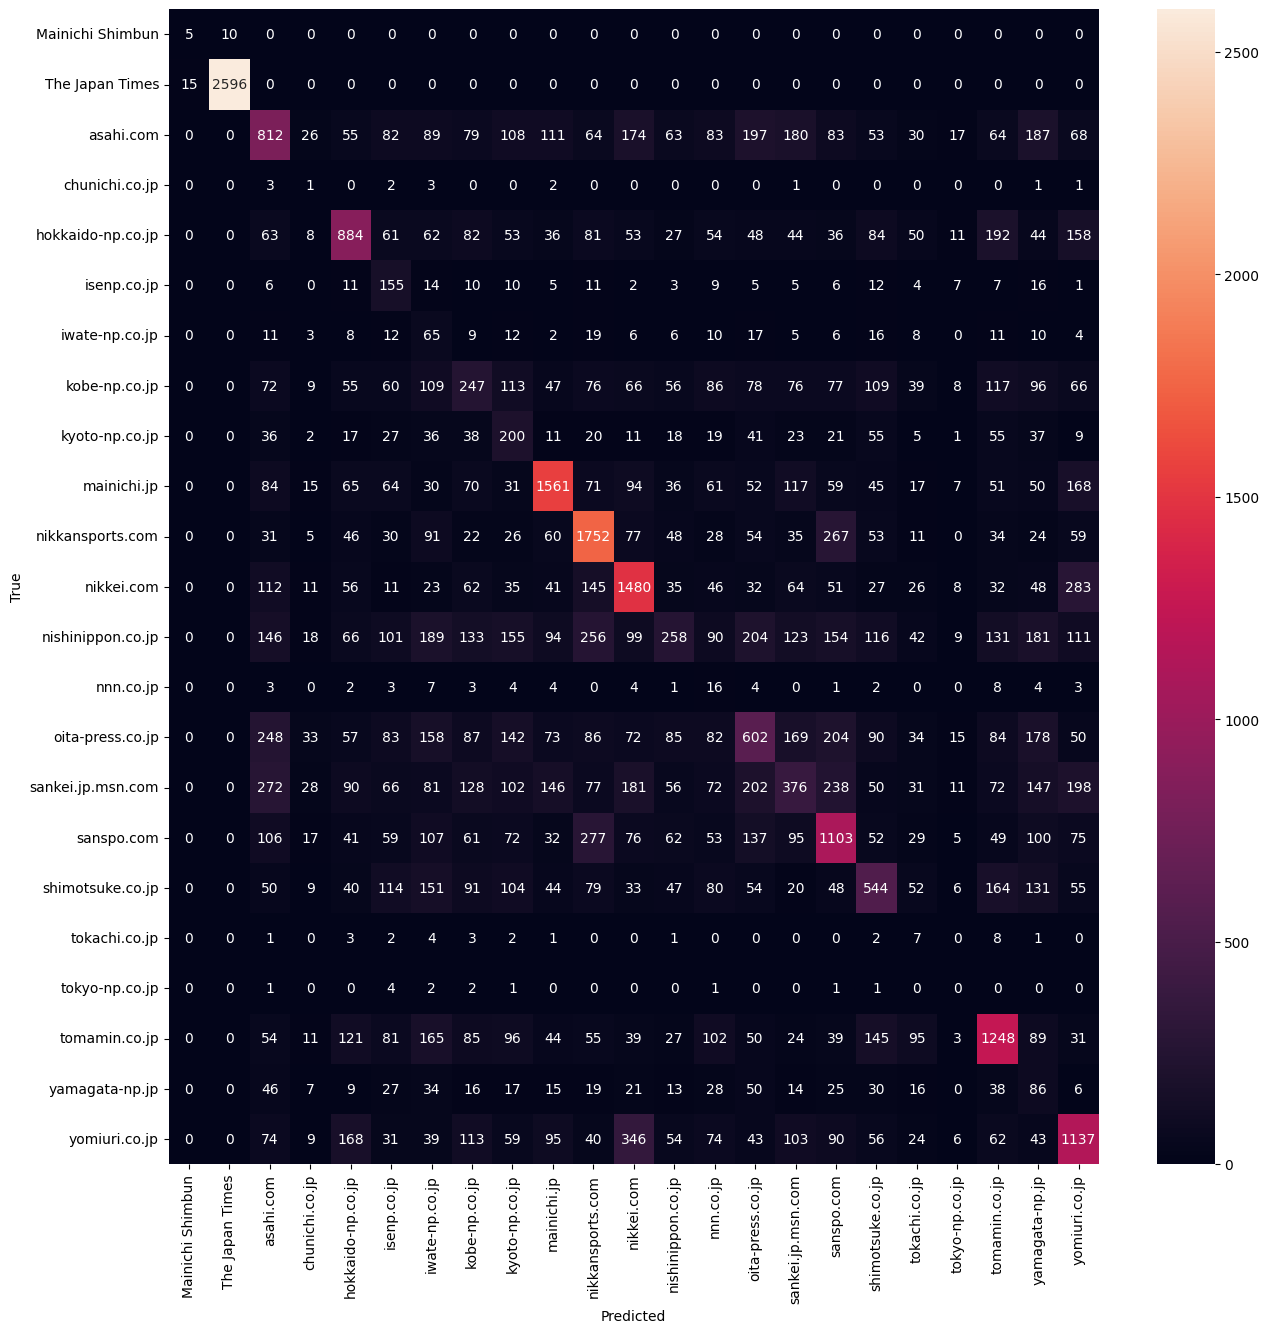

In [ ]:
plot_confusion_matrix(X_test_embeddings,y_test,y_pred)

In [ ]:
# MLP Classifier
mlp=MLPClassifier(activation="tanh", solver="adam", hidden_layer_sizes=(500,), tol=0.01, early_stopping=True, random_state=42)
mlp.fit(X_sm_bert,y_sm_bert)
y_pred=mlp.predict(X_test_embeddings)

# Model evaluation
print("Train set:")
print(classification_report(y_sm_bert,mlp.predict(X_sm_bert),digits=4))
print("Test set:")
print(classification_report(y_test,y_pred,digits=4))

Train set:
                   precision    recall  f1-score   support

 Mainichi Shimbun     0.9998    1.0000    0.9999     11010
  The Japan Times     0.9999    0.9998    0.9999     11010
        asahi.com     0.4460    0.4851    0.4647     11010
   chunichi.co.jp     0.9984    0.9993    0.9988     11010
hokkaido-np.co.jp     0.7655    0.5602    0.6470     11010
      isenp.co.jp     0.9271    0.9875    0.9563     11010
   iwate-np.co.jp     0.9364    0.9793    0.9574     11010
    kobe-np.co.jp     0.5066    0.4404    0.4712     11010
   kyoto-np.co.jp     0.7085    0.8324    0.7655     11010
      mainichi.jp     0.5663    0.7661    0.6512     11010
 nikkansports.com     0.5936    0.7809    0.6745     11010
       nikkei.com     0.5902    0.7164    0.6472     11010
nishinippon.co.jp     0.4774    0.1930    0.2749     11010
        nnn.co.jp     0.9960    0.9997    0.9979     11010
 oita-press.co.jp     0.4831    0.3279    0.3907     11010
sankei.jp.msn.com     0.3231    0.3149    0.

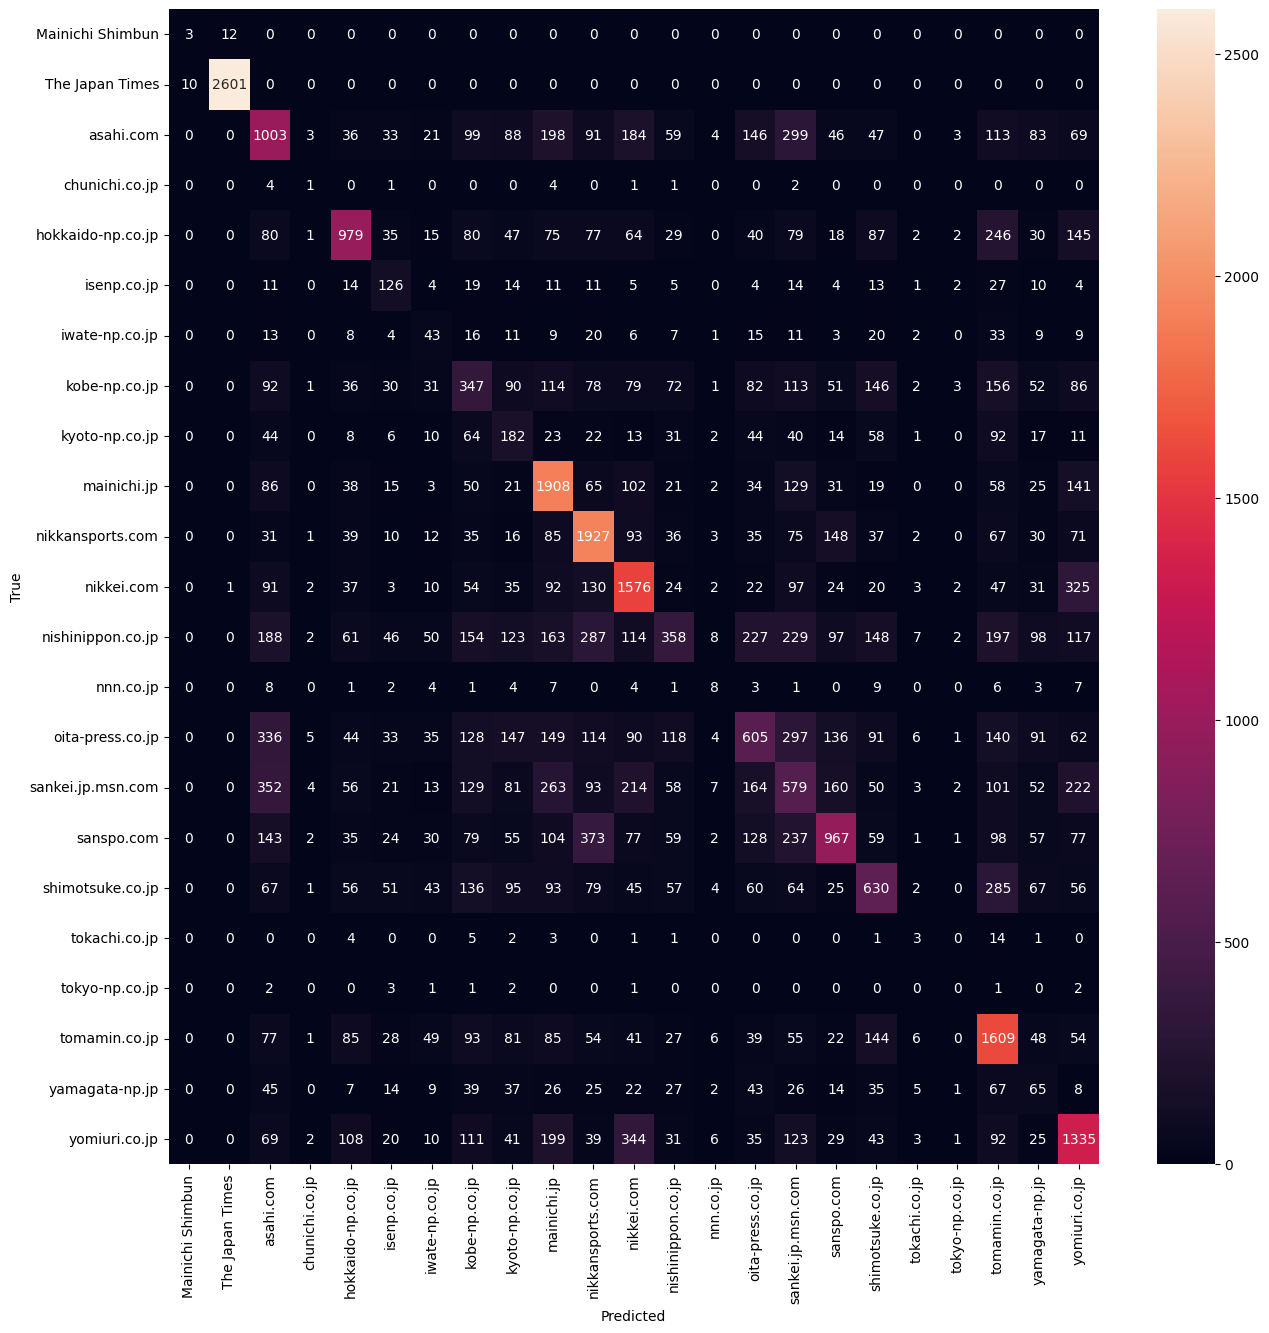

In [ ]:
plot_confusion_matrix(X_test_embeddings,y_test,y_pred)

In [ ]:
### THIS CELL NEED TOO MANY HOURS ###

# MLPClassifier with RandomSearch and Cross Validation

mlp = MLPClassifier()

# Parameters to test
parameters = {
    'hidden_layer_sizes': [(400,), (500,), (600,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.1),
    'tol': uniform(0.0001, 0.1)
}

#RandomizedSearchCV
random_search = RandomizedSearchCV(mlp, parameters, n_iter=3, cv=3, n_jobs=-1, verbose=2, random_state=42)

random_search.fit(X_sm_bert, y_sm_bert)

# Best parameters
print("Best parameters found:")
print(random_search.best_params_)

print("Best score:")
print(random_search.best_score_)

# Test set predictions
best_model = random_search.best_estimator_
y_pred_test = best_model.predict(X_test_embeddings)

print("Test set classification report:")
print(classification_report(y_test, y_pred_test))


In [ ]:
# RANDOM FOREST
rfc = RandomForestClassifier(n_estimators=70,            # Number of trees
                              max_features='sqrt',       # Number of features to consider for division
                              class_weight='balanced',   # Class balance
                             random_state=42)

# Model evaluation with cross-validation
#cv_scores = cross_val_score(rfc, X_sm_bert, y_sm_bert, cv=5, scoring='accuracy')

#print("Cross-Validation Scores:", cv_scores)
#print("Mean CV Accuracy:", cv_scores.mean())

rfc.fit(X_sm_bert, y_sm_bert)
y_pred=rfc.predict(X_test_embeddings)

# Model evaluation
print("Train set:")
print(classification_report(y_sm_bert,rfc.predict(X_sm_bert),digits=4))
print("Test set:")
print(classification_report(y_test,y_pred,digits=4))

Train set:
                   precision    recall  f1-score   support

 Mainichi Shimbun     1.0000    1.0000    1.0000     11010
  The Japan Times     1.0000    1.0000    1.0000     11010
        asahi.com     0.9999    0.9995    0.9997     11010
   chunichi.co.jp     1.0000    0.9999    1.0000     11010
hokkaido-np.co.jp     0.9995    0.9990    0.9993     11010
      isenp.co.jp     1.0000    1.0000    1.0000     11010
   iwate-np.co.jp     0.9998    1.0000    0.9999     11010
    kobe-np.co.jp     0.9991    0.9992    0.9991     11010
   kyoto-np.co.jp     1.0000    1.0000    1.0000     11010
      mainichi.jp     0.9976    0.9990    0.9983     11010
 nikkansports.com     0.9998    0.9995    0.9997     11010
       nikkei.com     0.9997    0.9999    0.9998     11010
nishinippon.co.jp     0.9995    0.9983    0.9989     11010
        nnn.co.jp     0.9999    1.0000    1.0000     11010
 oita-press.co.jp     0.9964    0.9982    0.9973     11010
sankei.jp.msn.com     0.9992    0.9985    0.

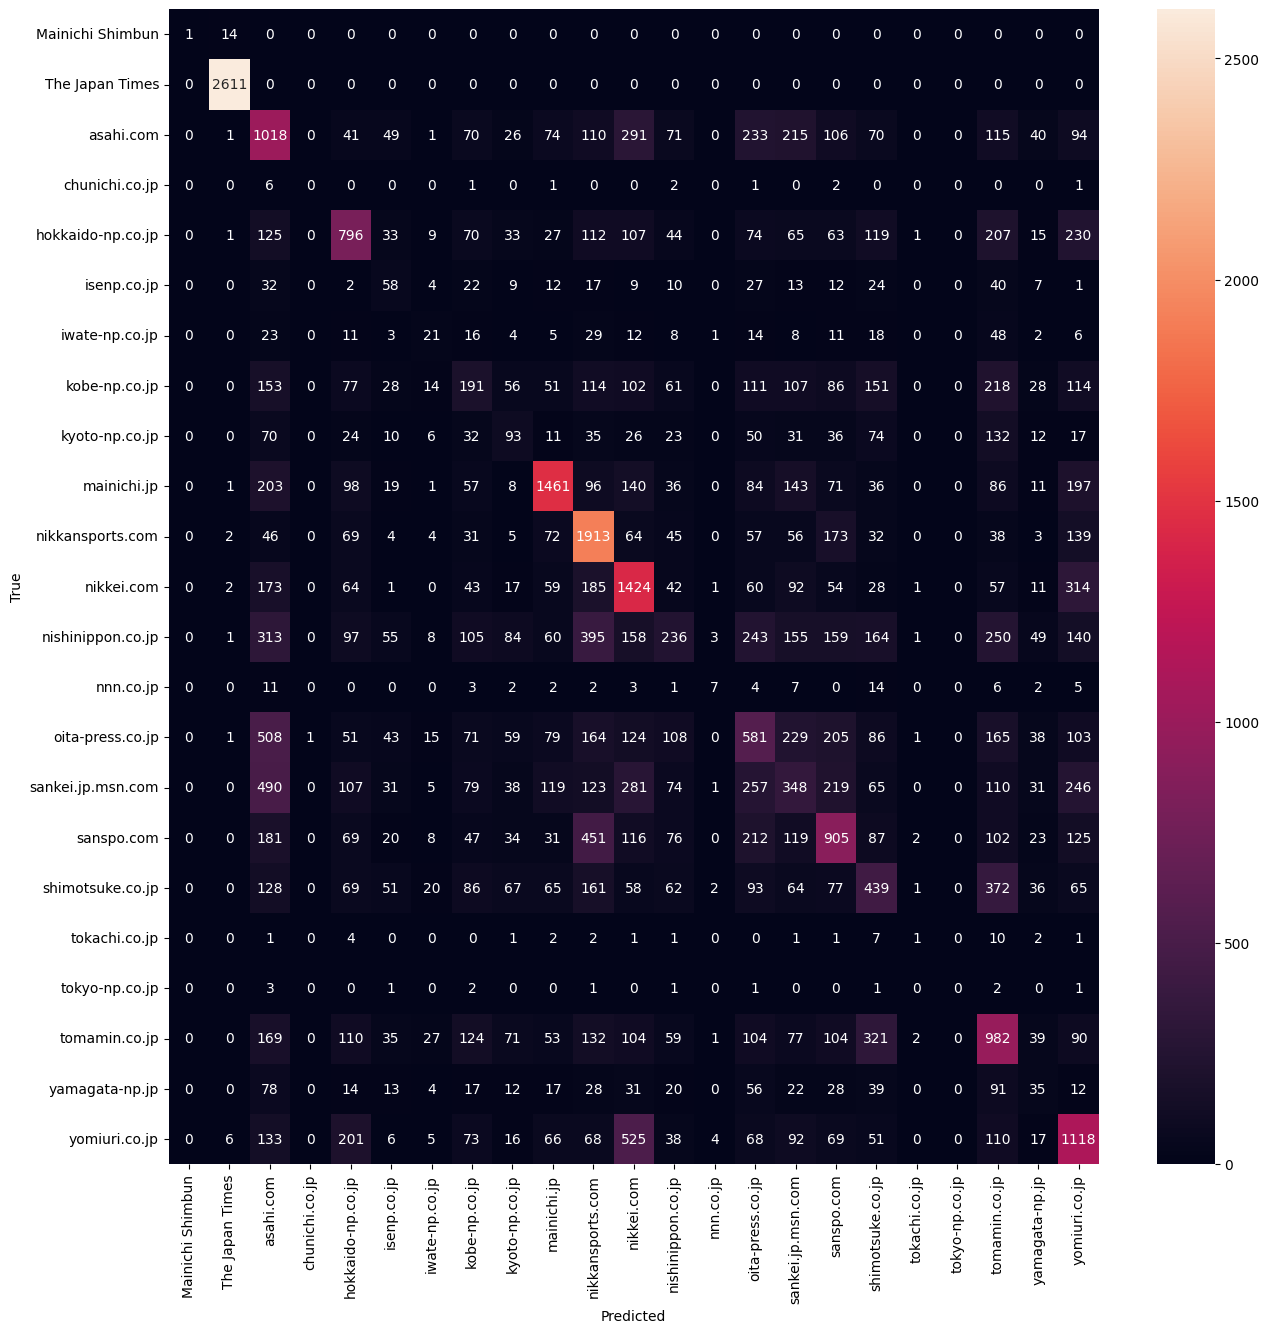

In [ ]:
plot_confusion_matrix(X_test_embeddings,y_test,y_pred)

In [ ]:
### THIS CELL NEED TOO MANY HOURS ####

# Random Forest with RandomSearch and Cross Validation

# Define parameters
param_grid = {
    'n_estimators': [50, 100, 200],                # Number of trees
    'max_depth': [5, 10, 20, None],                # Maximum tree depth
    'min_samples_split': [2, 5, 10],               # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],                 # Minimum number of samples required in a leaf
    'max_features': ['auto', 'sqrt'],              # Number of features to consider for division
    'class_weight': ['balanced', None]             # Class balance
}

# Create Random Forest model
rfc = RandomForestClassifier(random_state=42)

# Randomized Search CV
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)

rfc_random.fit(X_sm_bert, y_sm_bert)

print("Best Parameters:", rfc_random.best_params_)

# Model evaluate
y_pred = rfc_random.predict(X_test_embeddings)
print("Train set:")
print(classification_report(y_sm_bert,rfc.predict(X_sm_bert),digits=2))
print("Test set:")
print(classification_report(y_test, y_pred, digits=2))


# **Deep Learning**

#    GRU - LSTM - BILSTM




In [28]:
# Train, Validation and Test set
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset_undersampled['text'],
                                                            dataset_undersampled['source'],
                                                            test_size=0.2,
                                                            random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


In [29]:
# Preprocessing data for keras
def preprocess_text_for_classification(X_train, y_train, X_val, y_val, X_test, y_test, max_words = 1000, max_sequence_length = 100):

    # Text tokenizer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    # Tokenized sequences for train
    sequences_train = tokenizer.texts_to_sequences(X_train)
    padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length)

    # Tokenized sequences for validation
    sequences_val = tokenizer.texts_to_sequences(X_val)
    padded_sequences_val = pad_sequences(sequences_val, maxlen=max_sequence_length)

    # Tokenized sequences for test
    sequences_test = tokenizer.texts_to_sequences(X_test)
    padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

    # One-hot encoding for y_train, y_val and y_test
    y_train_encoded = pd.get_dummies(y_train)
    y_val_encoded = pd.get_dummies(y_val)
    y_test_encoded = pd.get_dummies(y_test)

    vocab_size = len(tokenizer.word_index) + 1

    return (padded_sequences_train, y_train_encoded), (padded_sequences_val, y_val_encoded), (padded_sequences_test, y_test_encoded), tokenizer, vocab_size


In [30]:
(padded_sequences_train, y_train_encoded), (padded_sequences_val, y_val_encoded), (padded_sequences_test, y_test_encoded), tokenizer, vocab_size = preprocess_text_for_classification(X_train, y_train, X_val, y_val, X_test, y_test, max_words=10000)


In [31]:
def plot_metrics(hist):

  plt.figure(figsize=(12,4))
  plt.subplot(1,4,1)
  plt.plot(hist.history["precision"],label="precision")
  plt.plot(hist.history["val_precision"],label="val_precision")
  plt.legend()
  plt.subplot(1,4,2)
  plt.plot(hist.history["recall"],label="recall")
  plt.plot(hist.history["val_recall"],label="val_recall")
  plt.legend()
  plt.subplot(1,4,3)
  plt.plot(hist.history["Accuracy"],label="Accuracy")
  plt.plot(hist.history["val_Accuracy"],label="val_Accuracy")
  plt.legend();
  plt.subplot(1,4,4)
  plt.plot(hist.history["loss"],label="loss")
  plt.plot(hist.history["val_loss"],label="val_loss")
  plt.legend();

In [32]:
# Oversampling with SMOTE
smote = SMOTE(random_state=42)

# Convert y_train_encoded to a numpy array
y_train_encoded_array = y_train_encoded.values

X_train_resampled, y_train_resampled = smote.fit_resample(padded_sequences_train, y_train_encoded_array)

# Verify dimension
print("Train set dimensions before oversampling:", padded_sequences_train.shape, y_train_encoded.shape)
print("Train set dimensions after oversampling:", X_train_resampled.shape, y_train_resampled.shape)


Train set dimensions before oversampling: (117655, 100) (117655, 23)
Train set dimensions after oversampling: (204240, 100) (204240, 23)


In [47]:
# GRU

# Creazione del modello GRU
model_GRU = Sequential()

model_GRU.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=100))

model_GRU.add(GRU(units=64))

model_GRU.add(Dropout(0.5))

model_GRU.add(Dense(units=23, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy','Precision','Recall'])

model_GRU.summary()

# Train model
history_GRU = model_GRU.fit(padded_sequences_train, y_train_encoded_array,
                         epochs=6, batch_size=64,
                         validation_data=(padded_sequences_val, y_val_encoded))

# Prediction
y_pred_prob_gru = model_GRU.predict(padded_sequences_test)
y_pred_gru = np.argmax(y_pred_prob_gru, axis=1)

# Converting labels to numeric format
y_test_numeric = y_test_encoded.idxmax(axis=1)
y_pred_numeric_gru = pd.Series(y_pred_gru).map({i: label for i, label in enumerate(y_test_encoded.columns)})


# Classification report
print("Test set (GRU):")
print(classification_report(y_test_numeric, y_pred_numeric_gru))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          14002560  
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 23)                1495      
                                                                 
Total params: 14041303 (53.56 MB)
Trainable params: 14041303 (53.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
1839/1839 [==============================] - 759s 411ms/step - loss: 1.9709 - Accuracy: 0.3799 - precision: 0.8369 - recall: 0.2017 - 

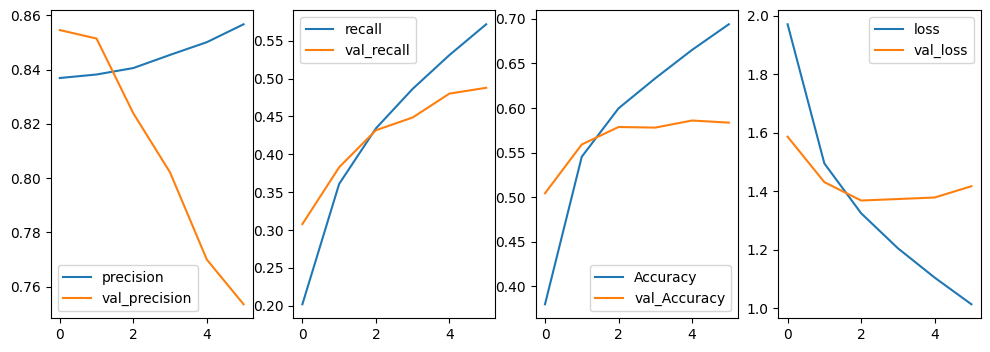

In [48]:
plot_metrics(history_GRU)

In [49]:
# LSTM

# Creazione del modello LSTM
model_LSTM = Sequential()

model_LSTM.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=100))

model_LSTM.add(LSTM(units=64, return_sequences=True))

model_LSTM.add(GlobalMaxPooling1D())

model_LSTM.add(Dense(units=32, activation='relu'))

model_LSTM.add(Dropout(0.5))

model_LSTM.add(Dense(units=23, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy','Precision','Recall'])

model_LSTM.summary()


# Train model
history_LSTM = model_LSTM.fit(padded_sequences_train, y_train_encoded_array,
                         epochs=6, batch_size=64,
                         validation_data=(padded_sequences_val, y_val_encoded))

# Prediction
y_pred_prob = model_LSTM.predict(padded_sequences_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Converting labels to numeric format
y_test_numeric = y_test_encoded.idxmax(axis=1)
y_pred_numeric = pd.Series(y_pred).map({i: label for i, label in enumerate(y_test_encoded.columns)})

# Classification report
print("Test set:")
print(classification_report(y_test_numeric, y_pred_numeric))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          14002560  
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 23)                759       
                                                      

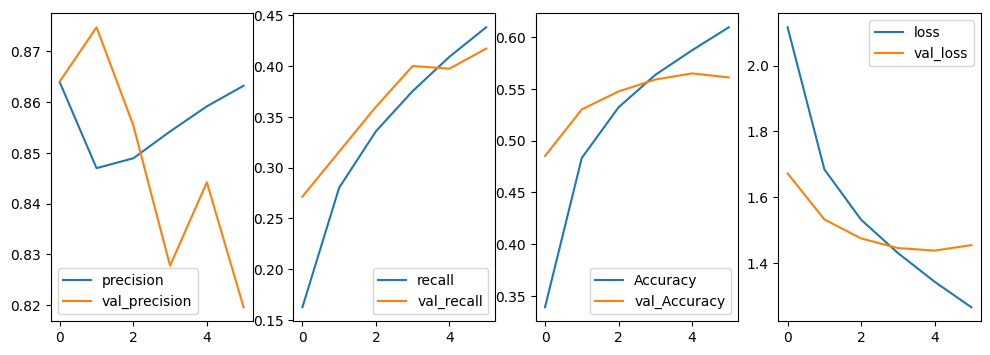

In [50]:
plot_metrics(history_LSTM)

In [51]:
# BILSTM

# Creazione del modello BILSTM
clear_session()

model_BILSTM = Sequential()

model_BILSTM.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=100))

model_BILSTM.add(Bidirectional(LSTM(64,return_sequences=True,activation="tanh",dropout=0.5)))

model_BILSTM.add(Flatten())

model_BILSTM.add(Dropout(0.5))

model_BILSTM.add(Dense(units=23, activation='softmax'))

model_BILSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy','Precision','Recall'])

model_BILSTM.summary()


# Train model
history_BILSTM = model_BILSTM.fit(padded_sequences_train, y_train_encoded_array,
                         epochs=6, batch_size=64,
                         validation_data=(padded_sequences_val, y_val_encoded))

# Prediction
y_pred_prob = model_BILSTM.predict(padded_sequences_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Converting labels to numeric format
y_test_numeric = y_test_encoded.idxmax(axis=1)
y_pred_numeric = pd.Series(y_pred).map({i: label for i, label in enumerate(y_test_encoded.columns)})

# Classification report
print("Test set:")
print(classification_report(y_test_numeric, y_pred_numeric))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          14002560  
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          98816     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 23)                294423    
                                                                 
Total params: 14395799 (54.92 MB)
Trainable params: 14395799 (54.92 MB)
Non-trainable params: 0 (0.00 Byte)
______________

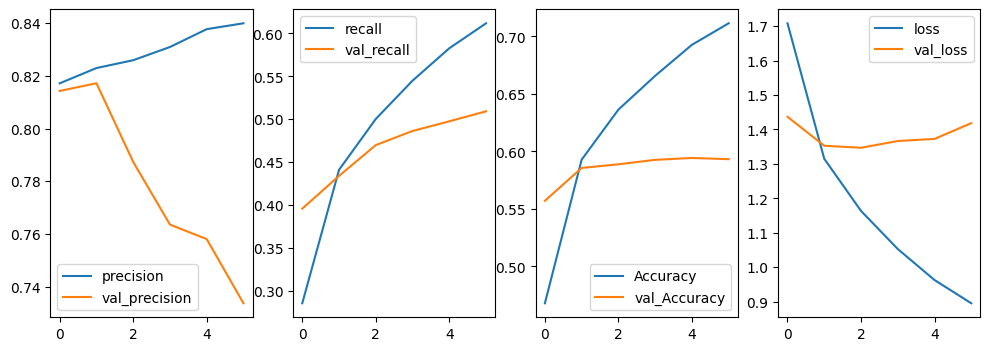

In [52]:
plot_metrics(history_BILSTM)

In [ ]:
# GPT

# Tokenizzazione del testo
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
X = [tokenizer.encode(text, padding='max_length', truncation=True, max_length=512) for text in dataset_undersampled['text']]

# Codifica delle etichette
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset_undersampled['source'])

# Divisione del dataset in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creazione del modello GPT
input_layer = Input(shape=(512,), dtype='int32')
gpt_model = TFGPT2Model.from_pretrained("gpt2", return_dict=True)
gpt_output = gpt_model(input_layer)[0]
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(gpt_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Addestramento del modello
model.fit(np.array(X_train), np.array(y_train), batch_size=4, epochs=3, validation_split=0.1)

# Valutazione del modello
y_pred = np.argmax(model.predict(np.array(X_test)), axis=-1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
